# Stage 1

This is the notebook for doing stage1 competition for training Predators and Prey agent which will hunt preys.

Implemented solution:
 
 * Process the state in such way that there will be  3 channels where first channel is the location of preys, second is the barriers and third is a centered location of the predator.
 * Limit the view for predators. The state was cut to 20x20 size.
 * For this stage the independent agent learning was applied, which means that during DQN only one predators was participating in hunting. The Logic was motivated by the fact if one can hunt the model can be applied to other predators.
 * The reward function is based on idea that its good to reward for making the right movement as well as giving reward for eating a prey. The more it eats the higher is coefficient for reward.

In [1]:
# Loading data
from world.realm import Realm
from world.map_loaders.base import MixedMapLoader
from world.map_loaders.single_team import SingleTeamLabyrinthMapLoader, SingleTeamRocksMapLoader
from world.utils import RenderedEnvWrapper
from world.envs import OnePlayerEnv
from world.scripted_agents import ClosestTargetAgent

In [17]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from itertools import count
from sys import getsizeof
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
from tqdm.notebook import tqdm

In [3]:
env =  RenderedEnvWrapper(OnePlayerEnv(Realm(MixedMapLoader(
    (SingleTeamLabyrinthMapLoader(), SingleTeamRocksMapLoader())
    ), 1, playable_team_size=1)))

### Scripted agent

In [4]:
agent = ClosestTargetAgent()
state, info = env.reset()
agent.reset(state,0)
done = False
count = 0
while  not done:
    action = agent.get_actions(state,0)
    next_state,done,info = env.step(action)
    state = next_state
env.render()


<img src="./render/301.gif" width="250" align="center">

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 3141

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

print(f'Device: {device}, seed: {SEED}')

Device: cpu, seed: 3141


### Essentials for working with state

In [6]:
def roll(arr, x, y):
    """
    arr is [barrier_mask, preys_mask, predators_mask]
    """
    height, width = arr.shape[1], arr.shape[2]
    dx = width // 2 - x
    dy = height // 2 - y
    res = np.roll(a=arr, shift=(dx, dy), axis=(2, 1))
    return res


def prepare_state(state):
    """
    Take state and return three masks: barrier positions, 
    preys positions and predator positions
    """
    barrier_mask = np.logical_and(state[:, :, 0] == -1, state[:, :, 1] == -1)
    preys_mask = state[:, :, 0] > 0
    predators_mask = np.logical_and(state[:, :, 0] == 0, state[:, :, 1] >= 0)
    return barrier_mask, preys_mask, predators_mask

def single_agent_state(state, info):
    res = prepare_state(state)
    res = np.stack(res)
    x, y = info['predators'][0]['x'], info['predators'][0]['y']
    centered = roll(res, x, y)
    return centered[:, 10:30, 10:30]

## DQN

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
                        
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQN(nn.Module):
    def __init__(self, input_dim=(20, 20, 3), output_dim=5):
        super().__init__()
#         self.output_dim = output_dim
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=7, stride=5, padding=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=5, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256, output_dim)            
        )
        
        
    def forward(self, x: torch.FloatTensor):
        return self.seq(x)

In [9]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([np.random.randint(0, high=5, size=1, dtype=int)], device=device, dtype=torch.long)

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    return loss.item()

In [11]:
def get_reward(
        info,
        step_reward=0.1,
        step_coef=0.99, 
        kill_reward=1.,
        kill_coef=1.01
        ):
    step = step_coef ** info['step'] * (np.array(info['true_action']) * step_reward)
    kill = kill_coef ** info['all_eated'] * (kill_reward * np.array(info['eated_on_step']))
    return step + kill


### Hyperparameters and essential initialisations

In [12]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.02
EPS_DECAY = 100000
TAU = 0.01
LR = 5 * 1e-4
TRANSITIONS = 1000
EVAL_STEP = 5
UPDATE_STEP = 500
NUM_EPISODES = 3000

In [13]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(50000)
steps_done = 0
n_actions = 5
best_score = 0

### Training module

In [14]:
def evaluation_two_map(model, episod):
    env = RenderedEnvWrapper(OnePlayerEnv(Realm(SingleTeamLabyrinthMapLoader(), 1, playable_team_size=1)))
    state, info = env.reset()
    state = torch.tensor(single_agent_state(state, info), dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    step = 0
    model.eval()
    while not done:
        action = model(state).max(1)[1].view(1, 1)
        state, done, info = env.step(action.squeeze(0).cpu().numpy())
        state = torch.tensor(single_agent_state(state, info), dtype=torch.float32, device=device).unsqueeze(0)
        step += 1
    env.render()
    score_1 = int(info['all_eated'][0])
    
    env = RenderedEnvWrapper(OnePlayerEnv(Realm(SingleTeamRocksMapLoader(), 1, playable_team_size=1)))
    state, info = env.reset()
    state = torch.tensor(single_agent_state(state, info), dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    step = 0
    while not done:
        action = model(state).max(1)[1].view(1, 1)
        state, done, info = env.step(action.squeeze(0).cpu().numpy())
        state = torch.tensor(single_agent_state(state, info), dtype=torch.float32, device=device).unsqueeze(0)
        step += 1
    env.render()
    score_2 = int(info['all_eated'][0])
    score_union = (score_1 + score_2) // 2
    return {
        'mean_score': score_union,
        'score_1': score_1,
        'score_2': score_2
    } 

In [15]:
episode_numbers = []
best_scores = []

  0%|          | 0/3000 [00:00<?, ?it/s]

/var/folders/nh/5_1n3ycs0f3g8ltxlc_pcr6m0000gn/T/ipykernel_2049/2408990318.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:276.)
  return torch.tensor([np.random.randint(0, high=5, size=1, dtype=int)], device=device, dtype=torch.long)


Mean:2, 1st:1, 2nd:4
Mean:8, 1st:9, 2nd:7
Mean:9, 1st:5, 2nd:14
Mean:11, 1st:8, 2nd:14
Mean:12, 1st:10, 2nd:14
Mean:14, 1st:12, 2nd:17
Mean:7, 1st:4, 2nd:11
Mean:13, 1st:6, 2nd:20
Mean:18, 1st:18, 2nd:18
Mean:16, 1st:11, 2nd:21
Mean:2, 1st:2, 2nd:3
Mean:15, 1st:14, 2nd:17


KeyboardInterrupt: 

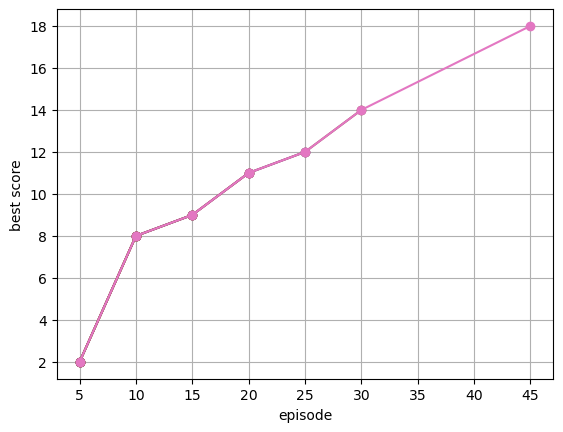

In [18]:
for i_episode in tqdm(range(NUM_EPISODES)):
    state, info = env.reset()
    state = torch.tensor(single_agent_state(state, info), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, done, info = env.step(action.squeeze(0).cpu().numpy())
        reward = torch.tensor(get_reward(info), dtype=torch.float32, device=device)
        next_state = torch.tensor(single_agent_state(observation, info), dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        loss = optimize_model()


        if steps_done % UPDATE_STEP == 0:
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)
            
        if done:
            break
    if i_episode and i_episode % EVAL_STEP == 0:
        eval_result = evaluation_two_map(policy_net, i_episode)
        print(f"Mean:{eval_result['mean_score']}, 1st:{eval_result['score_1']}, 2nd:{eval_result['score_2']}")
        if eval_result['mean_score'] > best_score:
            best_score = eval_result['mean_score']
            best_scores.append(best_score)
            episode_numbers.append(i_episode)
            plt.plot(episode_numbers, best_scores, marker='o', linestyle='-')
            plt.xlabel('episode')
            plt.ylabel('best score')
            plt.grid(True)
            
            plt.savefig(f'agent_training.png')
                

![title](agent_training.png)